In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from sklearn.naive_bayes import MultinomialNB


from sklearn import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

from keras.utils import plot_model
from keras import Model
from keras.layers import (Conv1D,
                          Dense,
                          Dropout,
                          Embedding,
                          Flatten,
                          GlobalMaxPooling1D,
                          Input,
                          LSTM,
                          TextVectorization)

df = pd.read_csv("survey2.csv")
df = df.drop('How do you usually relieve your stress', axis=1)
df = df.drop('Timestamp', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Meditation/gym/yoga or any other physical activity', axis=1)

df.rename(columns = {'Please select the option that best describes your current or past treatment/counseling status regarding mental health or emotional well-being:':'Past Treatment'}, inplace = True)
df.rename(columns = {'Do you have any family history of mental illnesses? Please select all that apply.':'Family History'}, inplace = True)
df.rename(columns = {'How often do you hang out with friends?':'Friends'}, inplace = True)
df.rename(columns = {'Do share the secrets and techniques you use to cope with stress. Please select all that apply.':'Techniques'}, inplace = True)
df.rename(columns = {'Have you ever taken to alcohol or drugs to distract yourself?':'Alcohol or drugs'}, inplace = True)
df.rename(columns = {'Sadness is a natural part of life. How frequently do you experience feelings of sadness? ':'Sadness'}, inplace = True)
df.rename(columns = {'How frequently do you experience feelings of irritability or anger?':'Anger'}, inplace = True)
df.rename(columns = {'Does your current organization provide any mental health support or resources?':'Support'}, inplace = True)
df.rename(columns = {"Sometimes we engage in activities that we know aren't the best for our mental health, but we still find ourselves doing them. Is there any activity or habit you frequently partake in, even though you're aware it may have a negative impact on your mental well-being?":'Negative activities'}, inplace = True)
df.rename(columns = {'Have you ever faced any significant traumatic events? This could include events such as accidents, natural disasters, violence, or other distressing experiences.':'Trauma'}, inplace = True)
df.rename(columns = {"It's totally normal to have triggers. What's something that triggers your mindset i.e something that makes you uncomfortable or reminds you of a difficult time?":'Triggers'}, inplace = True)
df.rename(columns = {'Finally, do you think you have had any mental illness before?':'Mental illness'}, inplace = True)


df['Negative activities']=df['Negative activities'].str.lower()
df['Triggers']=df['Triggers'].str.lower()
df['Trauma']=df['Trauma'].str.lower()
df['Techniques']=df['Techniques'].str.lower()

df['Negative activities'] = df['Negative activities'].str.replace(r'[^\w\s]+', '')
df['Triggers'] = df['Triggers'].str.replace(r'[^\w\s]+', '')
df['Trauma'] = df['Trauma'].str.replace(r'[^\w\s]+', '')

<ipython-input-317-feedd26831eb>:54: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Negative activities'] = df['Negative activities'].str.replace(r'[^\w\s]+', '')
<ipython-input-317-feedd26831eb>:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Triggers'] = df['Triggers'].str.replace(r'[^\w\s]+', '')
<ipython-input-317-feedd26831eb>:56: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Trauma'] = df['Trauma'].str.replace(r'[^\w\s]+', '')


In [ ]:
df['Negative activities'] = df['Negative activities'].fillna("no")
df['Alcohol or drugs'] = df['Alcohol or drugs'].fillna("no")
df['Trauma'] = df['Trauma'].fillna("no")
df['Triggers'] = df['Triggers'].fillna("no")
df['Family History'] = df['Family History'].fillna("no")


In [ ]:
df['Mental illness'] = df['Mental illness'].replace(['Big wood sickness '], 'Not any as such')
df['Mental illness'] = df['Mental illness'].replace(['Not any as such, During exams. Stomach mai gud gud '], 'Not any as such')
df['Mental illness'] = df['Mental illness'].replace(['Anger, overthinking '], 'Not any as such')
df['Mental illness'] = df['Mental illness'].replace(['PTSD', 'Not any as such, '], 'PTSD')
df['Mental illness'] = df['Mental illness'].replace(['Anxiety, Not any as such'], 'Anxiety')

display(df)

,Age,Gender,Employment,Past Treatment,Family History,Friends,We're curious to know:,Techniques,Alcohol or drugs,Sadness,Anger,Support,Negative activities,Trauma,Triggers,Mental illness,label
0,20,Female,Student,I have not undergone any treatment or counseling.,No,4,Love is in the air!,"a visit to the gym, spending time with friends...",Yes,3,2,No,social media like scrolling on instagram,yes,the siren of an ambulance,Not any as such,1
1,21,Male,Student,I have not undergone any treatment or counseling.,I do not have any family history of medical di...,3,Love is in the air!,"spending time with friends, going out with the...",No,2,3,No,no,no,when someone speaks wrongly about my character...,Not any as such,1
2,20,Male,Student,I have not undergone any treatment or counseling.,None,4,Cupid's arrow missed its mark :(,"a visit to the gym, listen to some music",no,3,4,Yes,no,no,no,Not any as such,0
3,21,Female,Student,I have undergone treatment or counseling in th...,Anxiety,4,Its complicated.,"spending time with friends, going out with the...",No,3,4,Yes,no,yes,fights and arguments,Not any as such,1
4,20,Male,Student,I have not undergone any treatment or counseling.,None,3,Cupid's arrow missed its mark :(,"spending time with friends, going out with the...","No, I consume in very limited quantity only on...",2,2,Yes,i dont think so,none,not that i know of,Not any as such,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,20,Female,Student,I am currently undergoing treatment or counsel...,"Anxiety, Depression",3,None of the above,"listen to some music, journaling, positive sel...",Yes,2,4,Yes,procrastination,no,no,Not any as such,0
217,20,Female,Student,I have not undergone any treatment or counseling.,not any as such,5,None of the above,"spending time with friends, going out with the...",Nah,4,5,No,no,no,my school days,Depression,1
218,20,Female,Unemployed,I have not undergone any treatment or counseling.,not any as such,2,None of the above,"spending time with friends, going out with the...",No,3,4,Yes,no,no,when someone makes me feel left out or belittl...,Not any as such,1
219,19,Male,Student,I am currently undergoing treatment or counsel...,Depression,3,Love is in the air!,"meditation and yoga, binge on shows and movies...",No,4,3,No,no,no,no,Bipolar disorder,0


In [ ]:

#df['Mental illness']= label_encoder.fit_transform(df['Mental illness'])

alc = df['Alcohol or drugs'].tolist()

for i in range(len(alc)):
  if (alc[i] == 'No' or alc[i] == 'no' or alc[i] == 'Nope' or alc[i] == 'No. Driving is all I need. '
  or alc[i] == 'Nah' or alc[i] == 'Never to distract' or alc[i] == 'Never' or alc[i] == 'No Never ' or alc[i] == 'NO'
  or alc[i] == 'nope' or alc[i] == 'Nahhh' or alc[i] == 'Nay' or alc[i] == 'Not even once ' or alc[i] == 'Nope, not interested'
  or alc[i] == 'haha no :)' or alc[i] == "I'm 14? No?"):
    alc[i] = 0

  else:
    alc[i] = 1

df['Alcohol or drugs'] = alc


In [ ]:
illness = df['Mental illness'].tolist()
#print(illness)
for i in range(len(illness)):
  if illness[i] == 'Not any as such':
    illness[i] = 0

  elif (illness[i] == 'Anxiety' or illness[i] == 'Depression' or illness[i] == 'PTSD' or
    illness[i] == 'Anxiety, Depression' or illness[i] == 'Anxiety, PTSD' or illness[i] == 'Depression, PTSD'
    or illness[i] == 'Anxiety, Depression, PTSD' or illness[i] == 'Anxiety, High Stress' or
    illness[i] == 'Anxiety, Depression, PTSD, Schizophrenia ' or illness[i] == 'Bipolar disorder '):
      illness[i] = 1

df['Mental illness'] = illness

trauma = df['Trauma'].tolist()

for i in range(len(trauma)):
  if (trauma[i] == 'No' or trauma[i] == 'no' or trauma[i] == 'none' or trauma[i] == 'not in the recent past'
  or trauma[i] == 'not really ' or trauma[i] == 'nothing as such' or trauma[i] == 'not yet' or trauma[i] == 'nope'
  or trauma[i] == 'nop' or trauma[i] == 'luckily nothing major' or trauma[i] == 'nay'
  or trauma[i] == 'not really any ' or trauma[i] == 'noo'):
    trauma[i] = 0

  else:
    trauma[i] = 1

df['Trauma'] = trauma

display(df)



,Age,Gender,Employment,Past Treatment,Family History,Friends,We're curious to know:,Techniques,Alcohol or drugs,Sadness,Anger,Support,Negative activities,Trauma,Triggers,Mental illness,label
0,20,Female,Student,I have not undergone any treatment or counseling.,No,4,Love is in the air!,"a visit to the gym, spending time with friends...",1,3,2,No,social media like scrolling on instagram,1,the siren of an ambulance,0,1
1,21,Male,Student,I have not undergone any treatment or counseling.,I do not have any family history of medical di...,3,Love is in the air!,"spending time with friends, going out with the...",0,2,3,No,no,0,when someone speaks wrongly about my character...,0,1
2,20,Male,Student,I have not undergone any treatment or counseling.,None,4,Cupid's arrow missed its mark :(,"a visit to the gym, listen to some music",0,3,4,Yes,no,0,no,0,0
3,21,Female,Student,I have undergone treatment or counseling in th...,Anxiety,4,Its complicated.,"spending time with friends, going out with the...",0,3,4,Yes,no,1,fights and arguments,0,1
4,20,Male,Student,I have not undergone any treatment or counseling.,None,3,Cupid's arrow missed its mark :(,"spending time with friends, going out with the...",1,2,2,Yes,i dont think so,0,not that i know of,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,20,Female,Student,I am currently undergoing treatment or counsel...,"Anxiety, Depression",3,None of the above,"listen to some music, journaling, positive sel...",1,2,4,Yes,procrastination,0,no,0,0
217,20,Female,Student,I have not undergone any treatment or counseling.,not any as such,5,None of the above,"spending time with friends, going out with the...",0,4,5,No,no,0,my school days,1,1
218,20,Female,Unemployed,I have not undergone any treatment or counseling.,not any as such,2,None of the above,"spending time with friends, going out with the...",0,3,4,Yes,no,0,when someone makes me feel left out or belittl...,0,1
219,19,Male,Student,I am currently undergoing treatment or counsel...,Depression,3,Love is in the air!,"meditation and yoga, binge on shows and movies...",0,4,3,No,no,0,no,1,0


In [ ]:
# Count labels
df["label"].value_counts()

0    121
1    100
Name: label, dtype: int64

In [ ]:
total_words =  ' '.join(df['Triggers'].values)
unique_words = set(total_words.lower().split())

print(f"Total words: {len(total_words.split())} | Unique words: {len(unique_words)}")


Total words: 754 | Unique words: 336


In [ ]:
word_count = pd.value_counts(total_words.split())
word_count.sort_values(ascending=False) # Sorted from most frequent

no             87
i              27
when           19
people         17
of             15
               ..
think           1
deeper          1
changes         1
drastically     1
trust           1
Length: 336, dtype: int64

In [ ]:
word_count[:25]

no         87
i          27
when       19
people     17
of         15
to         15
my         15
the        14
nothing    14
and        13
me         12
not        12
in         11
or          8
about       7
a           7
as          7
someone     7
such        6
past        6
dont        6
none        6
being       6
yes         5
that        4
dtype: int64

In [ ]:
word_count[-25:]

behavior       1
others         1
see            1
caused         1
distress       1
peoples        1
meanness       1
scolded        1
parents        1
nil            1
particular     1
trapped        1
mindset        1
because        1
anger          1
around         1
giving         1
answers        1
still          1
struggling     1
texts          1
particularl    1
clothes        1
songs          1
trust          1
dtype: int64

In [ ]:
train_data, val_test_data = train_test_split(df,
                                             test_size=0.3,
                                             shuffle=True,
                                             random_state=112)
# Validation and Test splits
val_data, test_data = train_test_split(val_test_data,
                                       test_size=0.5,
                                       random_state=112) # Same seed to avoid mixing the data

In [ ]:
# Amount of data

print(f"""
Total train data: {len(train_data)}\n
Train data (each label):\n {train_data["label"].value_counts()}\n
{"*"*30}
Total validation data: {len(val_data)}\n
Validation data (each label):\n {val_data["label"].value_counts()}\n
{"*"*30}
Total test data: {len(test_data)}\n
Test data (each label):\n {test_data["label"].value_counts()}\n
""")


Total train data: 154

Train data (each label):
 0    82
1    72
Name: label, dtype: int64

******************************
Total validation data: 33

Validation data (each label):
 0    21
1    12
Name: label, dtype: int64

******************************
Total test data: 34

Test data (each label):
 0    18
1    16
Name: label, dtype: int64




In [ ]:
# Train splits
train_sentences = train_data["Triggers"].to_list()
train_labels = train_data["label"].to_numpy()
# Val splits
val_sentences = val_data["Triggers"].to_list()
val_labels = val_data["label"].to_numpy()
# Test splits
test_sentences = test_data["Triggers"].to_list()
test_labels = test_data["label"].to_numpy()

In [ ]:
print("Train samples:",len(train_sentences), len(train_labels))
print("Val samples:", len(val_sentences), len(val_labels))
print("Test samples:", len(test_sentences), len(test_labels))

Train samples: 154 154
Val samples: 33 33
Test samples: 34 34


In [ ]:
import random
# Some random samples
for i in range(5):
    rand_index = random.choice(train_data.axes[0])
    print("\nTexto:\n\n",train_data["Triggers"][rand_index])
    print("\nEtiqueta: ",train_data["label"][rand_index])
    print("*"*50)


Texto:

 when someone makes me feel left out or belittles me

Etiqueta:  1
**************************************************

Texto:

 no

Etiqueta:  0
**************************************************

Texto:

 nothing 

Etiqueta:  0
**************************************************

Texto:

 no

Etiqueta:  0
**************************************************

Texto:

 being compared 

Etiqueta:  1
**************************************************


In [ ]:
# Random sentence
print("Random sentence:\n\n", random.choice(train_sentences))

Random sentence:

 no


In [ ]:
# Some labels
train_labels[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
#Using MultinomialNB algorithm and tf-idf as vectorizer.
# Scikit-learn pipeline (requires tuples (name, algorithm))
baseline = pipeline.Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("multinomial", MultinomialNB())
])

# Fitting pipeline
baseline.fit(train_sentences, train_labels);

# Checking validation score
print("Baseline accuracy score:")
baseline.score(val_sentences, val_labels)

Baseline accuracy score:


0.9696969696969697

In [ ]:
#Results baseline
# Function to calculate accuracy, precision, recall and f1-score
def calculate_metrics(y_true, y_pred):
    """
    Args:
    ----
    y_pred - Pred labels
    y_true - True labels

    Return:
    ----
    Return a dictionary with the model metrics of Accuracy, Precision, Recall and F1-score.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    return {"accuracy":accuracy,
           "precision":precision,
           "f1-score":f1,
           "recall":recall}

In [ ]:
# Get predicted labels
baseline_preds = baseline.predict(val_sentences)
baseline_preds[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
# Get final results on validation data
baseline_results = calculate_metrics(val_labels, baseline_preds)
baseline_results

{'accuracy': 0.9696969696969697,
 'precision': 0.9710743801652892,
 'f1-score': 0.9693905689861201,
 'recall': 0.9696969696969697}

In [ ]:
# As a dataframe
pd.DataFrame(baseline_results, index=["baseline_scores"])

,accuracy,precision,f1-score,recall
baseline_scores,0.969697,0.971074,0.969391,0.969697


In [ ]:
#Text vectorizer
# Get a list of our sentences lengths
sentence_len = []
for sentence in train_data["Triggers"]:
    sentence_len.append(len(sentence.split()))
print(sentence_len[:10])

[5, 1, 1, 2, 3, 1, 1, 1, 1, 1]


In [ ]:
# Average lengths
int(np.round(np.sum(sentence_len)/len(train_data)))

3

In [ ]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 99, 100]
percentiles_dict = {}
for percentil in percentiles:
    percentiles_dict[str(percentil) + "th percentil"] = np.percentile(sentence_len, percentil)

In [ ]:
pd.DataFrame(percentiles_dict, index=["Percentiles"]).T

,Percentiles
0th percentil,1.00
5th percentil,1.00
10th percentil,1.00
25th percentil,1.00
50th percentil,2.00
75th percentil,4.00
90th percentil,9.00
95th percentil,12.00
99th percentil,18.88
100th percentil,23.00


In [ ]:
# What happens if we take the highest value?
total_words = np.sum(sentence_len)
total_sentences = len(sentence_len)
with_9 = np.multiply(total_sentences, 9)
with_max_len = np.multiply(total_sentences, 23)

print("Total words:", total_words)
print("Total elements using 9 as maximum length:", with_9)
print("Total elements using the maximum length:", with_max_len)
print(f"Proportion of zeros (max length): {np.divide((with_max_len - total_words), with_max_len) * 100:.3}%")

Total words: 527
Total elements using 9 as maximum length: 1386
Total elements using the maximum length: 3542
Proportion of zeros (max length): 85.1%


In [ ]:
# Vectorizer layer
vocab_size = 10000 # Number of words for our vocabulary
max_sentence_length = 4 # Max sentence length

text_vectorizer = TextVectorization(max_tokens=vocab_size,
                                    output_sequence_length=max_sentence_length)

In [ ]:
# Adapting vocabulary to our training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Checking the configuration of our vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_5',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 10000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 4,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 265}

In [ ]:
# Checking some words of the vocabulary
vocab = text_vectorizer.get_vocabulary()
print("Top words:", vocab[:10])
print("Last words:", vocab[-10:])

Top words: ['', '[UNK]', 'no', 'i', 'people', 'when', 'to', 'my', 'me', 'and']
Last words: ['answer', 'anger', 'an', 'ambulance', 'agreeing', 'agitates', 'actually', 'actress', 'academic', 'abt']


In [ ]:
# Vectorized sample
random_sentence = random.choice(train_sentences)
vec_sentence = text_vectorizer([random_sentence])

print("Random sentence:\n", random_sentence)
print("\nVectorized sentence:\n", vec_sentence)
print("\nVectorized sentence shape:", vec_sentence.shape)

Random sentence:
 nothing

Vectorized sentence:
 tf.Tensor([[11  0  0  0]], shape=(1, 4), dtype=int64)

Vectorized sentence shape: (1, 4)


In [ ]:
#Word embeddings
# Creating embedding layer
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=128,
                            name="Embedding_0")

In [ ]:
# Visualizing embeddings
embedded_sentence = embedding_layer(vec_sentence) # It takes our vectorizer outputs

print("Embedded sentence:\n\n", embedded_sentence)
print("\nEmbedded sentence shape:\n\n", embedded_sentence.shape)

Embedded sentence:

 tf.Tensor(
[[[-0.01401953 -0.00895475  0.0252085  -0.00996267  0.04225205
   -0.0249173  -0.03088434 -0.01528009  0.01012828  0.00648325
   -0.04458387  0.01995205  0.0203385  -0.04969558 -0.00727795
   -0.03356548  0.0367628   0.02059657 -0.00079469  0.01405453
   -0.04088364 -0.01596763  0.0260538  -0.00739037  0.03174586
   -0.01211987 -0.01158353 -0.03988336  0.02784791 -0.00749194
    0.01714161 -0.0127327  -0.0317464  -0.01061969 -0.01917215
    0.02754206 -0.00719824  0.03176009 -0.04628681 -0.04437618
   -0.03274803 -0.00424588 -0.00877343 -0.01287907 -0.04849961
   -0.02962551 -0.03927239 -0.0066094  -0.03127225  0.00476957
    0.00331235 -0.02954639 -0.00232059 -0.03845818  0.04908193
   -0.01651837  0.0456604  -0.01314378  0.016889    0.00496559
   -0.01388892 -0.04030869 -0.01798062 -0.0036125   0.00083072
   -0.01229254  0.0329696  -0.00553016 -0.04129819 -0.01906726
    0.03980364 -0.04546683  0.03167219 -0.01044279  0.02240113
    0.0238727   0.02690

In [ ]:
# Creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

In [ ]:
# Batching and prefetching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Amount of batches
len(train_dataset), len(val_dataset), len(test_dataset)

(5, 2, 2)

In [ ]:
# Each batch
for sent, labels in train_dataset.take(1):
    print("First sentence in the first batch:\n\n", sent[0])
    print("\nFirst label in the first batch:", labels[0])
    print(f"\nAmount of sentences (per batch): {len(sent)}\nAmount of labels (per batch): {len(labels)}")

First sentence in the first batch:

 tf.Tensor(b'not that i know of', shape=(), dtype=string)

First label in the first batch: tf.Tensor(0, shape=(), dtype=int64)

Amount of sentences (per batch): 32
Amount of labels (per batch): 32


In [ ]:
# Creating Dense model on Functional API

inputs = Input(shape=(1,), dtype=tf.string) # Input layer
vectorizer = text_vectorizer(inputs) # Vectorizer layer
encoder = embedding_layer(vectorizer) # Embedding layer
dense = Dense(4, activation="relu")(encoder) # Simple Dense layer
flatten = Flatten()(encoder) # Flatten layer
outputs = Dense(1, activation="sigmoid")(flatten) # Dense output layer

model_dense = Model(inputs, outputs) # Putting it together

In [ ]:
# Compiling
model_dense.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
# Checking summary
model_dense.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 4)                0         
 ectorization)                                                   
                                                                 
 Embedding_0 (Embedding)     (None, 4, 128)            1280000   
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,280,513
Trainable params: 1,280,513
Non-trainable params: 0
________________________________________________

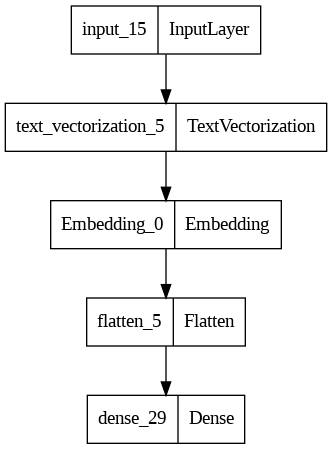

In [ ]:
# Plotting model
plot_model(model_dense)

In [ ]:
# Training model for 20 epochs
model_dense_history = model_dense.fit(train_dataset,
                                      epochs=20,
                                      validation_data=val_dataset)

Epoch 1/20
5/5 [==============================] - 1s 89ms/step - loss: 0.6866 - accuracy: 0.6169 - val_loss: 0.6623 - val_accuracy: 0.7576
Epoch 2/20
5/5 [==============================] - 0s 27ms/step - loss: 0.6484 - accuracy: 0.8506 - val_loss: 0.6261 - val_accuracy: 0.8182
Epoch 3/20
5/5 [==============================] - 0s 26ms/step - loss: 0.6133 - accuracy: 0.8571 - val_loss: 0.5919 - val_accuracy: 0.7879
Epoch 4/20
5/5 [==============================] - 0s 23ms/step - loss: 0.5794 - accuracy: 0.8506 - val_loss: 0.5591 - val_accuracy: 0.8182
Epoch 5/20
5/5 [==============================] - 0s 24ms/step - loss: 0.5463 - accuracy: 0.8506 - val_loss: 0.5274 - val_accuracy: 0.8182
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.5135 - accuracy: 0.8571 - val_loss: 0.4969 - val_accuracy: 0.8182
Epoch 7/20
5/5 [==============================] - 0s 22ms/step - loss: 0.4811 - accuracy: 0.8766 - val_loss: 0.4680 - val_accuracy: 0.8182
Epoch 8/20
5/5 [===========

In [ ]:
def get_model_preds(model, dataset, y_true):
    """
    Recibes a model and a validation or test dataset and return the predictions of the model.

    Args:
    ----
    model (Keras Model) - Model used to make predictions.
    dataset (Dataset) - val/test dataset to evaluate the model.
    y_true (array) - True labels to calculate the model results.

    Returns:
    --------
    pred_probs (array) - Prediction probabilities of the model on the dataset.
    preds (array) - Predicted labels of the model on the dataset.
    results (dict) - The model results (accuracy, precision, recall, f1-score)
    """
    pred_probs = model.predict(dataset) # Prediction probabilities
    preds = tf.squeeze(tf.round(pred_probs)) # Predicted labels
    results = calculate_metrics(y_true, preds) # Results dictionary
    return pred_probs, preds, results

In [ ]:
# Getting our model predictions and results
model_dense_pred_probs, model_dense_preds, dense_results = get_model_preds(model_dense,
                                                                           val_dataset,
                                                                           val_labels)

2/2 [==============================] - 0s 6ms/step


In [ ]:
print("Pred probs samples:\n\n", model_dense_pred_probs[:10])
print("\nPred labels samples:\n\n", model_dense_preds[:10])

Pred probs samples:

 [[0.5208488 ]
 [0.07124963]
 [0.07124963]
 [0.07124963]
 [0.28547397]
 [0.07124963]
 [0.6586594 ]
 [0.5364022 ]
 [0.07124963]
 [0.0760412 ]]

Pred labels samples:

 tf.Tensor([1. 0. 0. 0. 0. 0. 1. 1. 0. 0.], shape=(10,), dtype=float32)


In [ ]:
def results_table(names, *args):
    """
    Model results updatable table funcion. Receives model results as arguments
    in dictionary form and returns a dataframe to display and compare them.

    Args:
    -----
    model_names (list): List with the names of the models to display in the table (Same amount than *args).
    *args (dict): As many dictionaries of results as models to evaluate (Same amount than model_names).
    """
    results_dict = {}
    for index, arg in enumerate(args):
        results_dict[names[index]] = arg

    return pd.DataFrame(results_dict).T

In [ ]:
results_table(["Baseline", "Dense"], baseline_results, dense_results)

,accuracy,precision,f1-score,recall
Baseline,0.969697,0.971074,0.969391,0.969697
Dense,0.909091,0.909091,0.908172,0.909091


In [ ]:
#LSTM
# Crreating custom embedding layer
embedding_lstm = Embedding(input_dim=vocab_size,
                           output_dim=128,
                           name="Embedding_lstm")

# Creating LSTM model on Functional API

inputs = Input(shape=(1,), dtype=tf.string) # Input layer
vectorizer = text_vectorizer(inputs) # Vectorizer layer
encoder = embedding_lstm(vectorizer) # Embedding layer
lstm = LSTM(units=8, activation="relu")(encoder) # LSTM layer
dropout = Dropout(0.2)(lstm)
dense = Dense(4, activation="relu")(dropout)

outputs = Dense(1, activation="sigmoid")(dense) # Dense output layer

model_lstm = Model(inputs, outputs) # Putting it together

In [ ]:
# Compiling
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy"])
# Checking summary
model_lstm.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 4)                0         
 ectorization)                                                   
                                                                 
 Embedding_lstm (Embedding)  (None, 4, 128)            1280000   
                                                                 
 lstm_5 (LSTM)               (None, 8)                 4384      
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_30 (Dense)            (None, 4)                 36        
                                                          

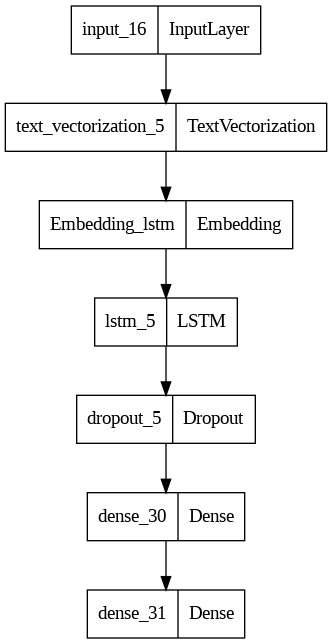

In [ ]:
# Plotting model
plot_model(model_lstm)

In [ ]:
# Training model for 20 epochs
model_LSTM_history = model_lstm.fit(train_dataset,
                                    epochs=20,
                                    validation_data=val_dataset)

Epoch 1/20
5/5 [==============================] - 2s 90ms/step - loss: 0.6920 - accuracy: 0.5584 - val_loss: 0.6861 - val_accuracy: 0.6364
Epoch 2/20
5/5 [==============================] - 0s 28ms/step - loss: 0.6877 - accuracy: 0.5779 - val_loss: 0.6800 - val_accuracy: 0.6364
Epoch 3/20
5/5 [==============================] - 0s 20ms/step - loss: 0.6826 - accuracy: 0.5714 - val_loss: 0.6734 - val_accuracy: 0.6364
Epoch 4/20
5/5 [==============================] - 0s 20ms/step - loss: 0.6781 - accuracy: 0.5844 - val_loss: 0.6654 - val_accuracy: 0.6364
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 0.6719 - accuracy: 0.6039 - val_loss: 0.6555 - val_accuracy: 0.6364
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6660 - accuracy: 0.6039 - val_loss: 0.6430 - val_accuracy: 0.6970
Epoch 7/20
5/5 [==============================] - 0s 20ms/step - loss: 0.6576 - accuracy: 0.6494 - val_loss: 0.6275 - val_accuracy: 0.8182
Epoch 8/20
5/5 [===========

In [ ]:
# Getting our model results
_, lstm_preds, lstm_results = get_model_preds(model_lstm,
                                      val_dataset,
                                      val_labels)

2/2 [==============================] - 0s 5ms/step


In [ ]:
results_table(["Baseline","Dense", "LSTM"], baseline_results, dense_results, lstm_results)

,accuracy,precision,f1-score,recall
Baseline,0.969697,0.971074,0.969391,0.969697
Dense,0.909091,0.909091,0.908172,0.909091
LSTM,0.969697,0.971074,0.969391,0.969697


In [ ]:
#Conv1D model
# Custom embedding layer

embedding_conv = Embedding(input_dim=vocab_size,
                            output_dim=128,
                            name="Embedding_conv")

# Creating a convolutional model (Functional API)

inputs = Input(shape=(1,), dtype=tf.string) # Input layer
vectorizer = text_vectorizer(inputs) # Vectorizer layer
encoder = embedding_conv(vectorizer) # Embedding layer
conv_layer = Conv1D(64, 5, 1, padding="same")(encoder) # Convolutional layer
max_pooling = GlobalMaxPooling1D()(conv_layer) # Max Pooling layer
dense = Dense(32, activation="relu")(max_pooling) # Extra Dense layer
outputs = Dense(1, activation="sigmoid")(dense) # Output layer

model_conv = Model(inputs=inputs,
                   outputs=outputs,
                   name="model_Conv1D") # Putting it together

# Compiling
model_conv.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Tuned learning_rate
                   metrics=["accuracy"])

# Checking summary
model_conv.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 4)                0         
 ectorization)                                                   
                                                                 
 Embedding_conv (Embedding)  (None, 4, 128)            1280000   
                                                                 
 conv1d_4 (Conv1D)           (None, 4, 64)             41024     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_32 (Dense)            (None, 32)               

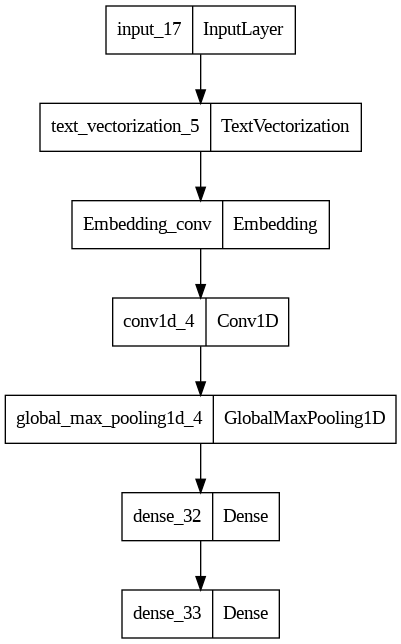

In [ ]:
plot_model(model_conv)

In [ ]:
model_conv_history = model_conv.fit(train_dataset,
                                        epochs=20,
                                        validation_data=val_dataset)

Epoch 1/20
5/5 [==============================] - 1s 65ms/step - loss: 0.6905 - accuracy: 0.5714 - val_loss: 0.6876 - val_accuracy: 0.7273
Epoch 2/20
5/5 [==============================] - 0s 18ms/step - loss: 0.6839 - accuracy: 0.7922 - val_loss: 0.6818 - val_accuracy: 0.7273
Epoch 3/20
5/5 [==============================] - 0s 20ms/step - loss: 0.6789 - accuracy: 0.8117 - val_loss: 0.6765 - val_accuracy: 0.7879
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 0.6742 - accuracy: 0.8442 - val_loss: 0.6713 - val_accuracy: 0.8182
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6695 - accuracy: 0.8636 - val_loss: 0.6661 - val_accuracy: 0.8182
Epoch 6/20
5/5 [==============================] - 0s 19ms/step - loss: 0.6647 - accuracy: 0.8701 - val_loss: 0.6606 - val_accuracy: 0.8182
Epoch 7/20
5/5 [==============================] - 0s 20ms/step - loss: 0.6598 - accuracy: 0.8636 - val_loss: 0.6554 - val_accuracy: 0.8182
Epoch 8/20
5/5 [===========

In [ ]:
# Get results
_, conv_preds, conv_results = get_model_preds(model_conv,
                                     val_dataset,
                                     val_labels)

2/2 [==============================] - 0s 11ms/step


In [ ]:
final_results = results_table(["Baseline", "Dense", "LSTM", "Conv1D"], baseline_results,
                                                                          dense_results,
                                                                          lstm_results,
                                                                          conv_results)
final_results

,accuracy,precision,f1-score,recall
Baseline,0.969697,0.971074,0.969391,0.969697
Dense,0.909091,0.909091,0.908172,0.909091
LSTM,0.969697,0.971074,0.969391,0.969697
Conv1D,0.939394,0.944664,0.938017,0.939394


In [ ]:
# Evaluating our best model on test set

test_probs, test_preds, test_results = get_model_preds(model_lstm,
                                                       test_dataset,
                                                       test_labels)

test_results

2/2 [==============================] - 0s 5ms/step


{'accuracy': 0.9117647058823529,
 'precision': 0.9243697478991596,
 'f1-score': 0.9105944765173973,
 'recall': 0.9117647058823529}

In [ ]:
# Creating dataframe with the predctions
test_data["probabilities_triggers"] = test_probs # Column with probabilities of each label

display(test_data)

,Age,Gender,Employment,Past Treatment,Family History,Friends,We're curious to know:,Techniques,Alcohol or drugs,Sadness,Anger,Support,Negative activities,Trauma,Triggers,Mental illness,label,probabilities_triggers
200,14,Female,Student,I have not undergone any treatment or counseling.,Anxiety,4,None of the above,"work out, meditation and yoga, spending time w...",0,3,3,Yes,no,0,no,1,0,0.026204
41,20,Male,Student,I have not undergone any treatment or counseling.,not any as such,1,Love is in the air!,binge on shows and movies,1,1,1,Yes,no,1,no,0,0,0.026204
13,19,Male,Student,I have not undergone any treatment or counseling.,Nope,4,Love is in the air!,"a visit to the gym, spending time with friends...",0,1,1,No,no,0,not having enough sex,0,0,0.344539
72,21,Female,Unemployed,I have not undergone any treatment or counseling.,not any as such,3,It's complicated.,"work out, binge on shows and movies, listen to...",0,2,4,No,no,1,my past,1,1,0.631630
1,21,Male,Student,I have not undergone any treatment or counseling.,I do not have any family history of medical di...,3,Love is in the air!,"spending time with friends, going out with the...",0,2,3,No,no,0,when someone speaks wrongly about my character...,0,1,0.633898
127,19,Female,Student,I have not undergone any treatment or counseling.,not any as such,5,Cupid's arrow missed its mark :(,"meditation and yoga, spending time with friend...",0,3,3,No,scrolling insta mindlessly,1,when i hear a news of someones death i remembe...,1,1,0.650537
203,14,Female,Student,I have not undergone any treatment or counseling.,not any as such,5,None of the above,"binge on shows and movies, listen to some musi...",0,3,3,No,uh no,0,nothing,0,0,0.026106
198,36,Male,Employed,I have not undergone any treatment or counseling.,not any as such,2,It's complicated.,"work out, meditation and yoga, spending time w...",0,1,1,Yes,yes i work in a corporate,1,memories pop up randomly,0,1,0.577056
84,21,Female,Student,I have not undergone any treatment or counseling.,not any as such,4,Cupid's arrow missed its mark :(,"spending time with friends, going out with the...",0,3,3,No,noi havent done such things,1,change in their priorities about me,0,1,0.532644
196,20,Female,Student,I have not undergone any treatment or counseling.,not any as such,4,Love is in the air!,"spending time with friends, going out with the...",0,3,3,Yes,no,0,no,0,0,0.026204
